# Time Series Machine Learning - Sheet 1
22/03/2024

Autors:
- Jesus David Mora Venegas
- Nicolay Agustin Cerda Cortez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import scipy
import random

## Exercise 1
1. Write a function `flatten_relative_and_full_ts_df(df)` that takes a dataframe, in which rows are subjects/instances, columns are features, and each cell is a sorted iterable (list, numpy array, Series). The output is a dataframe with a column for the subject (this can be just some integer, e.g, what previously used to be the index), one for the timestamp, and one other for each sensor.
This function assumes (and indicates in its name) that the time series objects are com- plete in the sense that even if a piece of information is missing, then this is indicated through a np.nan. Since the lists describing the time series have no timestamp yet, this timestamp is inferred implicitly from the observations’ index in the list.

In [2]:
df = pd.read_csv('db/ieeeppg.csv', delimiter=';').iloc[:1000]

In [3]:
def flatten_relative_and_full_ts_df(df):
    new_data = []
    for c in df:
        try:
            df[c] = df[c].apply(json.loads)
        except:
            print(f"The col {c} is allready a list.")
    for row_index, col in df.iterrows():
        for sensor, values in col.items():
            for timestamp, value in enumerate(values):
                if value == None:
                    value = np.nan
                new_data.append({
                    'subject': row_index,
                    'timestamp': timestamp,
                    'sensor': sensor,
                    'value': value
                })

    df_flatten = pd.DataFrame(new_data).pivot_table(index=['subject', 'timestamp'], columns='sensor', values='value').reset_index()
    return df_flatten
test = flatten_relative_and_full_ts_df(df)

In [4]:
test

sensor,subject,timestamp,PPG1,PPG2,x-accelerometer,y-accelerometer,z-accelerometer
0,0,0,-23.0,4.0,-0.0702,0.3432,0.9594
1,0,1,NaN,6.0,-0.0702,0.3588,0.9438
2,0,2,-26.5,3.0,-0.0546,0.3666,0.9360
3,0,3,-27.0,3.5,-0.0468,0.3666,0.9360
4,0,4,-30.0,0.0,-0.0468,0.3744,0.9126
...,...,...,...,...,...,...,...
999995,999,995,-184.0,-103.0,-1.9734,2.4804,0.8268
999996,999,996,-191.5,-89.0,-1.8018,2.4804,0.6942
999997,999,997,-195.0,-70.5,-1.6770,2.3478,0.5694
999998,999,998,-195.0,-48.5,-1.6380,2.1450,0.4914


2. Write a function `insert_times(df, timestamps, sub_col="x", time_col="timestamp")`
that generates, for each subject, all timestamps according to the time scheme defined in `timestamps`, which is a list or Series, and inserts respective rows into (a copy of) `df` with `np.nan` values for all datapoints.
This function assumes that `df` is in the flattened format. `sub_col` and `time_col` simply indicate the names of the columns that contain the subjects and the timestamps, respectively.

In [5]:
test['subject'].value_counts()

subject
0      1000
671    1000
658    1000
659    1000
660    1000
       ... 
338    1000
339    1000
340    1000
341    1000
999    1000
Name: count, Length: 1000, dtype: int64

In [6]:
def insert_times(df, timestamps, sub_col="x", time_col="timestamp"):
    # Create a copy of the dataframe
    df_copy = df.copy()
    
    # If timestamps is a list, convert it to a Series
    if isinstance(timestamps, list):
        timestamps = pd.Series(timestamps)

    # Get unique subjects from the dataframe
    unique_subjects = df_copy[sub_col].unique()
    
    # Iterate over each subject
    for subject in unique_subjects:
        # Get the rows for the current subject
        subject_rows = df_copy[df_copy[sub_col] == subject]
        
        # Generate the missing timestamps for the subject
        missing_timestamps = timestamps[~timestamps.isin(subject_rows[time_col])]
        
        # Create new rows with np.nan values for the missing timestamps
        new_rows = pd.DataFrame({sub_col: subject, time_col: missing_timestamps})
        new_rows = new_rows.reindex(columns=df_copy.columns)
        
        # Append the new rows to the dataframe
        df_copy = pd.concat([df_copy, new_rows], ignore_index=True)
    
    return df_copy


Define timestamps

In [7]:
# # ACTIVAR ESTE SI QUEREMOS UN TIMESTAMP DE FECHAS

# time1=pd.to_datetime('2020-01-01 00:00:00')
# time2 =time1 + pd.Timedelta(seconds=999)

# # Generate the timestamps list using the defined time scheme
# timestamps = pd.date_range(start=time1, end=time2, freq='s').strftime('%Y-%m-%d %H:%M:%S').tolist()


In [8]:
timestamps=list(range(0,1200))

In [9]:
len(timestamps)

1200

In [10]:
#Ejecutar la función
df_copy = insert_times(test, timestamps, sub_col="subject", time_col="timestamp")

In [11]:
df_copy

sensor,subject,timestamp,PPG1,PPG2,x-accelerometer,y-accelerometer,z-accelerometer
0,0,0,-23.0,4.0,-0.0702,0.3432,0.9594
1,0,1,NaN,6.0,-0.0702,0.3588,0.9438
2,0,2,-26.5,3.0,-0.0546,0.3666,0.9360
3,0,3,-27.0,3.5,-0.0468,0.3666,0.9360
4,0,4,-30.0,0.0,-0.0468,0.3744,0.9126
...,...,...,...,...,...,...,...
1199995,999,1195,NaN,NaN,NaN,NaN,NaN
1199996,999,1196,NaN,NaN,NaN,NaN,NaN
1199997,999,1197,NaN,NaN,NaN,NaN,NaN
1199998,999,1198,NaN,NaN,NaN,NaN,NaN


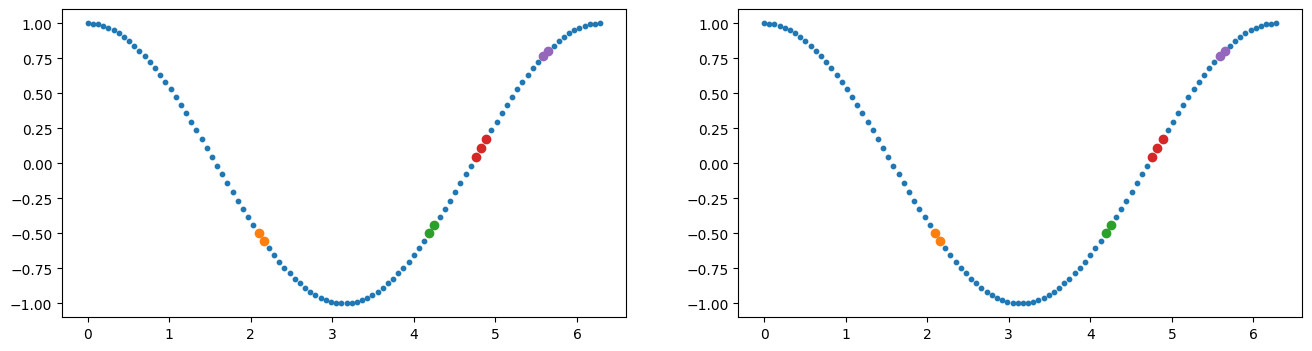

In [12]:
# average, linear, cubic, barycentric
fig,axs = plt.subplots(1,2,figsize=(16,4))
# x = df_copy.loc[df_copy['subject'] == 0]
# y = x['timestamp']

# axs[0].scatter(x['PPG1'],y)
data_x = np.linspace(0,2*np.pi,100) #TimeStamp
y = np.cos(data_x)
for n in range(5):
    y[random.randint(2,97)] = np.nan

index_nan = np.isnan(y)
num_imputation = np.count_nonzero(index_nan)
size = 10

for ax in axs:
    ax.scatter(data_x[~index_nan],y[~index_nan],s =size)
    nan_blocks = np.where(np.diff(index_nan.astype(int)))[0]
    for i in range(0, len(nan_blocks), 2):
        ax.scatter(data_x[nan_blocks[i]:nan_blocks[i+1]+1],np.interp(x=data_x[nan_blocks[i]:nan_blocks[i+1]+1],
                  xp=[data_x[nan_blocks[i]-1],data_x[nan_blocks[i+1]+1]],
                  fp=[y[nan_blocks[i]-1], y[nan_blocks[i+1]+1]]))
        

In [13]:
df_copy

sensor,subject,timestamp,PPG1,PPG2,x-accelerometer,y-accelerometer,z-accelerometer
0,0,0,-23.0,4.0,-0.0702,0.3432,0.9594
1,0,1,NaN,6.0,-0.0702,0.3588,0.9438
2,0,2,-26.5,3.0,-0.0546,0.3666,0.9360
3,0,3,-27.0,3.5,-0.0468,0.3666,0.9360
4,0,4,-30.0,0.0,-0.0468,0.3744,0.9126
...,...,...,...,...,...,...,...
1199995,999,1195,NaN,NaN,NaN,NaN,NaN
1199996,999,1196,NaN,NaN,NaN,NaN,NaN
1199997,999,1197,NaN,NaN,NaN,NaN,NaN
1199998,999,1198,NaN,NaN,NaN,NaN,NaN


In [69]:
def impute(df, technique=1, reach=2, lookahead=False, sub_col="subject", time_col="timestamp"):
    df_copy = df.copy()
    nan_data = {}
    nan_block = {}
    for col in df_copy.columns:
        if col not in (sub_col, time_col):
            nan_data[col] = np.where(np.isnan(df.iloc[:27005][col]))[0]

    for n in nan_data:
        nan_block[n] = []
        for d in nan_data[n]:
            lim_inf = 0 if d-reach < 0 else d-reach
            lim_sup = len(df_copy[n])-1 if d+reach+1 > len(df_copy[n])-1 else d+reach+1
            nan_block[n].append([d,[df_copy[n][lim_inf:d],df_copy[n][d+1:lim_sup]]])
            
    return (nan_block)

d = impute(df_copy.iloc[:27005])


In [70]:
d

{'PPG1': [[1,
   [0   -23.0
    Name: PPG1, dtype: float64,
    2   -26.5
    3   -27.0
    Name: PPG1, dtype: float64]],
  [5004,
   [5002   -11.0
    5003   -12.0
    Name: PPG1, dtype: float64,
    5005   -12.0
    5006   -12.5
    Name: PPG1, dtype: float64]],
  [8001,
   [7999     8.0
    8000   -16.5
    Name: PPG1, dtype: float64,
    8002   -11.0
    8003    -9.5
    Name: PPG1, dtype: float64]],
  [14010,
   [14008    1.5
    14009    3.0
    Name: PPG1, dtype: float64,
    14011    1.5
    14012    1.5
    Name: PPG1, dtype: float64]],
  [17003,
   [17001   -1.0
    17002    1.0
    Name: PPG1, dtype: float64,
    17004    1.5
    17005    2.5
    Name: PPG1, dtype: float64]],
  [26005,
   [26003   -63.0
    26004   -67.0
    Name: PPG1, dtype: float64,
    26006   -62.5
    26007   -59.5
    Name: PPG1, dtype: float64]]],
 'PPG2': [],
 'x-accelerometer': [[255,
   [253    0.4602
    254    0.4680
    Name: x-accelerometer, dtype: float64,
    256    0.4836
    257    0.4914


In [15]:
np.where(np.isnan(df_copy.iloc[:27005]['PPG1']))[0]

array([    1,  5004,  8001, 14010, 17003, 26005])

In [16]:
df_copy['PPG1'][5004]

nan